# Homework 3 Report - Alex Anderson and Dan Mossing

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import caffe

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [2]:
def get_split(split):
    filename = './development_kit/data/%s.txt' % split
    if not os.path.exists(filename):
        raise IOError('Split data file not found: %s' % split)
    return filename

def get_pred(base, source):
    return os.path.join(base, 'top_5_predictions.{}.csv'.format(source))

In [3]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [5]:
base_path = '/home/mossing/caffemodels_for_alex/*'

model_dirs = glob(base_path)

# Model Performance for different Architectures

We investigated a variety of different alex-net like architectures. In particular, we tried making the network deeper by adding convolutional layers and by making the network skinnier by reducing the number of filters in each layer. Overall, our results showed that making a deeper network improved performance above the baseline by about 5 percent. 

In [6]:
for split in ['train', 'val']:
    data = pd.read_csv(get_split(split), sep=' ', header=None, names=['image', 'true_label'])
    for q, model_dir in enumerate(model_dirs):
        name = model_dir.split('/')[-1]
        print 'Model name: {}'.format(name)
#         print 'Split: {}'.format(split)
        tmp = ['{}label{}'.format(name, i) for i in [1,2,3,4,5]]
        pred = pd.read_csv(get_pred(model_dir, split), header=True, names=(['image'] + tmp))
        data = pd.merge(data, pred, on='image')

        top1 = (data['true_label'] == data['{}label1'.format(name)]).mean()
        print 'Split: {:6}, Top 1 accuracy: {:.2f} %'.format(split, top1 * 100)

Model name: skinny
Split: train , Top 1 accuracy: 38.57 %
Model name: deeper
Split: train , Top 1 accuracy: 49.83 %
Model name: skinny_fat
Split: train , Top 1 accuracy: 41.08 %
Model name: too_deep
Split: train , Top 1 accuracy: 53.06 %
Model name: diff_deeper
Split: train , Top 1 accuracy: 52.55 %
Model name: even_deeper
Split: train , Top 1 accuracy: 55.07 %
Model name: skinny
Split: val   , Top 1 accuracy: 31.47 %
Model name: deeper
Split: val   , Top 1 accuracy: 39.75 %
Model name: skinny_fat
Split: val   , Top 1 accuracy: 33.22 %
Model name: too_deep
Split: val   , Top 1 accuracy: 40.05 %
Model name: diff_deeper
Split: val   , Top 1 accuracy: 40.03 %
Model name: even_deeper
Split: val   , Top 1 accuracy: 40.28 %


# Plot the first layer filters

In order to investigate the convergence of our network, we are visualizing the filters in the first layer. We can see that we get a number of gray scale filters that pick out different frequency components and we get some color opponent channels. It is evident that the colors are present at lower frequencies in the image (due to jpeg compression). It seems like the features are much more noisy compared to the filters generated by CNNs trained on larger datasets. Perhaps more data or stronger weight decay could result in filters that were less noisy. 

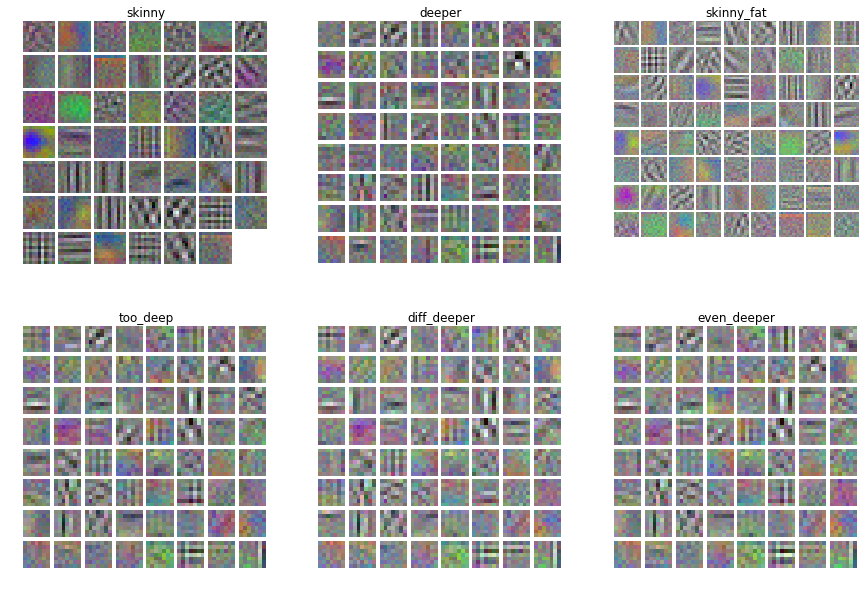

In [10]:
plt.figure(figsize=(15, 10))
for i, model_dir in enumerate(model_dirs):
    proto_fn = glob(model_dir + '/*proto*')[0]
    model_fn = glob(model_dir + '/snapshot/*50000.caffemodel')[0]

    net = caffe.Net(proto_fn, model_fn, caffe.TEST)

    plt.subplot(2, 3, i+1)
    plt.title(model_dir.split('/')[-1])
    filters = net.params['conv0'][0].data
    vis_square(filters.transpose(0, 2, 3, 1))

# Confusion Matrix

Here, we look at the confusion matrix and identify the hardest categories to classify for the trained model that performed the best on the validation set. We can see that there were seven categories that were classified at or below chance. On the top end, there were certain categories that were very reliably classified (although unlikely to be close to human performance). 

In [11]:
from sklearn.metrics import confusion_matrix

In [15]:
cm = confusion_matrix(data['true_label'], data['even_deeperlabel1'])

In [37]:
cat = pd.read_csv('development_kit/data/categories.txt', 
                  sep=' ', header=None, names=['category', 'label'])
cat['val_correct'] = np.diag(cm) / (1. * cm.shape[0])
cat['mus_ind_error'] = cm[69] / 100.
cat['river_error'] = cm[79] / 100.

In [46]:
print cat.sort('val_correct').head(10)
print cat.sort('val_correct').tail(10)

                category  label  val_correct  mus_ind_error  river_error
69      /m/museum/indoor     69         0.06           0.06         0.00
37        /c/coffee_shop     37         0.07           0.01         0.00
78         /r/restaurant     78         0.09           0.01         0.00
79              /r/river     79         0.10           0.00         0.10
67  /m/monastery/outdoor     67         0.10           0.00         0.00
39  /c/construction_site     39         0.10           0.00         0.02
24             /b/bridge     24         0.13           0.01         0.01
34     /c/clothing_store     34         0.16           0.01         0.00
42          /c/courtyard     42         0.17           0.02         0.00
10        /b/bakery/shop     10         0.18           0.03         0.00
                    category  label  val_correct  mus_ind_error  river_error
15         /b/baseball_field     15         0.65           0.01         0.00
57                /i/iceberg     57        

Looking at two categories that are at chance for tope 1, indoor museum and river, we see some reasonable errors. For instance, the indoor museum gets misclassified as a lobby, art gallery, and a bookstore. Likewise, the river gets miscategorized as a swamp, hot spring, harbor, and rainforest. 

In [41]:
cat.sort('mus_ind_error').tail()

,category,label,val_correct,mus_ind_error,river_error
89,/s/staircase,89,0.37,0.05,0
20,/b/bookstore,20,0.45,0.05,0
69,/m/museum/indoor,69,0.06,0.06,0
6,/a/art_gallery,6,0.39,0.07,0
63,/l/lobby,63,0.18,0.07,0


In [42]:
cat.sort('river_error').tail()

,category,label,val_correct,mus_ind_error,river_error
77,/r/rainforest,77,0.37,0,0.06
52,/h/harbor,52,0.32,0,0.06
79,/r/river,79,0.10,0,0.10
55,/h/hot_spring,55,0.36,0,0.10
92,/s/swamp,92,0.38,0,0.11


# Conclusions

While the errors of the network were semantically meaningful, the overall feeling that I got from this work is that the effort to optimize the convolutional network doesn't lead to more understanding. Eg. going back into the network, I haven't been able to intuitively understand what features that can be used to differentiate one place scene from another, whereas I could clearly do that by looking at the different images and trying to understand them. I am also curious to know for the future how much improvement could be obtained by using transfer learning.  

Another general comment is that it seems quite hard to make rapid changes to caffe compared with other deep learning programs (at least the documentation is hard to read). For instance, there are a number of other label preserving transformations that one could do in principle such as adjusting the contrast by manipulating the histograms, warping the image, etc. But it is hard to make these changes due to the somewhat rigid structure of adding new layers in caffe. 